# FNN Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import os
os.chdir("/home/dalai/GNN_E")

import pandas as pd
from math import ceil
import gc
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import torch
import torch.optim as optim

# Out libraries
from utils_models import *
from FNN.FNN_model import *

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)

/home/dalai/.conda/envs/gat_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
cuda
1.13.1+cu116


In [2]:
# Load all movies with labels csv
#df_all_movies = pd.read_csv("data/processed/all_movies_labelled_13_single.csv")
df_all_movies = pd.read_csv("data/processed/all_movies_labelled_13_single_balanced.csv")

num_classes = 13 # based on df_movie choosen
batch_size = 32
test_train_splitting_mode = "Vertical"
percentage_train = 0.8
percentage_val = 0.2


# Df rest only in case you want to predict between rest and movie
df_rest = pd.read_csv("/home/dalai/GNN_E/data/raw/rest/Rest_compiled414_processed.csv")

In [3]:
if test_train_splitting_mode == "Vertical":
    #df_train, df_test = split_train_test_vertically(
    #    df_all_movies, 
    #   test_movies_dict = {"BigBuckBunny": 2, "FirstBite": 4, "Superhero": 9})
    # In case use balanced dataset
    df_train, df_test = split_train_test_vertically(
        df_all_movies, 
        test_movies_dict = {"FirstBite": 4, "Superhero": 9, "YouAgain": 13})
    df_val = df_train[df_train.id == 99] #make sure to be empty
elif test_train_splitting_mode == "Horizontal":
    df_train, df_val, df_test = split_train_val_test_horizontally(
        df_all_movies, 
        percentage_train=percentage_train, 
        percentage_val=percentage_val, #0 to not have nay val set
        path_pickle_delay="data/raw/labels/run_onsets.pkl",
        path_movie_title_mapping="data/raw/labels/category_mapping_movies.csv", 
        tr_len=1.3)
elif test_train_splitting_mode == "MovieRest":
    df_rest = pd.read_csv("data/raw/rest/Rest_compiled414_processed.csv")
    df_train, df_test = split_train_test_rest_classification(df_all_movies, df_rest)
    df_val = df_train[df_train.id == 99] #make sure to be empty

In [4]:
half_wind_size = 4

X_train, y_train = create_feature_label_tensors_for_FNN(
    df_train, 
    sizewind=half_wind_size
)
print(X_train.shape) # samples x nodes x window
print(y_train.shape) # samples

X_test, y_test = create_feature_label_tensors_for_FNN(
    df_test, 
    sizewind=half_wind_size
)
print(X_test.shape) # samples x nodes x window
print(y_test.shape) # samples

Movies in this df: [ 0  1  2  3  5  6  7  8 10 11 12]
Processing movie: 0, subject: 1, timepoint: 0/178
Processing movie: 0, subject: 1, timepoint: 5/178
Processing movie: 0, subject: 1, timepoint: 7/178
Processing movie: 0, subject: 1, timepoint: 9/178
Processing movie: 0, subject: 1, timepoint: 11/178
Processing movie: 0, subject: 1, timepoint: 13/178
Processing movie: 0, subject: 1, timepoint: 15/178
Processing movie: 0, subject: 1, timepoint: 16/178
Processing movie: 0, subject: 1, timepoint: 18/178
Processing movie: 0, subject: 1, timepoint: 19/178
Processing movie: 0, subject: 1, timepoint: 21/178
Processing movie: 0, subject: 1, timepoint: 23/178
Processing movie: 0, subject: 1, timepoint: 24/178
Processing movie: 0, subject: 1, timepoint: 25/178
Processing movie: 0, subject: 1, timepoint: 26/178
Processing movie: 0, subject: 1, timepoint: 27/178
Processing movie: 0, subject: 1, timepoint: 29/178
Processing movie: 0, subject: 1, timepoint: 30/178
Processing movie: 0, subject: 1,

In [5]:
# Reshape to (samples, nodes * window)

samples_train = X_train.shape[0]
X_train = X_train.view(samples_train, -1)  # or X.reshape(samples, nodes * window)
print(X_train.shape)

samples_test = X_test.shape[0]
X_test = X_test.view(samples_test, -1)  # or X.reshape(samples, nodes * window)
print(X_test.shape)

torch.Size([84354, 3726])
torch.Size([28356, 3726])


In [6]:
# Move tensors to gpu
X_train.to(device)
y_train.to(device)
X_test.to(device)
y_test.to(device)

tensor([7, 7, 7,  ..., 2, 2, 2], device='cuda:0')

In [7]:
# Create Model

n_nodes = 414

model = FNN(
    input_size = n_nodes * (1 + 2*half_wind_size), #n_features = n_nodes x window_size
    output_size = num_classes, #n_classes, it return softmax
    hidden_dims = [1500, 300, 100],  # List of hidden layer sizes #[1500, 1000, 500, 300, 100]
    initializer="he"
)

model.to(device)

summary(model, (batch_size, n_nodes * (1 + 2*half_wind_size)))  # Adjust input size accordingly


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 32, 1500]       5,590,500
         LeakyReLU-2             [-1, 32, 1500]               0
            Linear-3              [-1, 32, 300]         450,300
         LeakyReLU-4              [-1, 32, 300]               0
            Linear-5              [-1, 32, 100]          30,100
         LeakyReLU-6              [-1, 32, 100]               0
            Linear-7               [-1, 32, 13]           1,313
Total params: 6,072,213
Trainable params: 6,072,213
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.45
Forward/backward pass size (MB): 0.93
Params size (MB): 23.16
Estimated Total Size (MB): 24.55
----------------------------------------------------------------


In [8]:
# Train

losses_train, losses_val = model.train_model(
                                X_train = X_train, 
                                Y_train = y_train,  
                                X_val = X_test, 
                                Y_val = y_test, 
                                optimizer="adam", 
                                learning_rate=0.0001, 
                                epochs=50, 
                                batch_size=batch_size
                    )

Epoch 1/50: 100%|██████████| 2637/2637 [00:09<00:00, 288.06batch/s]


Epoch 1/50, Train Loss: 5.9379, Val Loss: 3.3890


Epoch 2/50: 100%|██████████| 2637/2637 [00:08<00:00, 294.45batch/s]


Epoch 2/50, Train Loss: 2.3135, Val Loss: 3.3116


Epoch 3/50: 100%|██████████| 2637/2637 [00:08<00:00, 297.74batch/s]


Epoch 3/50, Train Loss: 1.9987, Val Loss: 3.6320


Epoch 4/50: 100%|██████████| 2637/2637 [00:08<00:00, 297.29batch/s]


Epoch 4/50, Train Loss: 1.6543, Val Loss: 4.0971


Epoch 5/50: 100%|██████████| 2637/2637 [00:08<00:00, 296.03batch/s]


Epoch 5/50, Train Loss: 1.2972, Val Loss: 4.4347


Epoch 6/50: 100%|██████████| 2637/2637 [00:09<00:00, 290.49batch/s]


Epoch 6/50, Train Loss: 1.0067, Val Loss: 5.1312


Epoch 7/50: 100%|██████████| 2637/2637 [00:08<00:00, 293.61batch/s]


Epoch 7/50, Train Loss: 0.7896, Val Loss: 5.7130


Epoch 8/50: 100%|██████████| 2637/2637 [00:09<00:00, 290.66batch/s]


Epoch 8/50, Train Loss: 0.6319, Val Loss: 6.2955


Epoch 9/50: 100%|██████████| 2637/2637 [00:09<00:00, 286.89batch/s]


Epoch 9/50, Train Loss: 0.5220, Val Loss: 6.5830


Epoch 10/50: 100%|██████████| 2637/2637 [00:09<00:00, 288.19batch/s]


Epoch 10/50, Train Loss: 0.4482, Val Loss: 7.3098


Epoch 11/50: 100%|██████████| 2637/2637 [00:09<00:00, 292.24batch/s]


Epoch 11/50, Train Loss: 0.3934, Val Loss: 7.6482


Epoch 12/50: 100%|██████████| 2637/2637 [00:09<00:00, 288.27batch/s]


Epoch 12/50, Train Loss: 0.3715, Val Loss: 8.1717


Epoch 13/50: 100%|██████████| 2637/2637 [00:09<00:00, 289.04batch/s]


Epoch 13/50, Train Loss: 0.3335, Val Loss: 8.4847


Epoch 14/50: 100%|██████████| 2637/2637 [00:09<00:00, 292.18batch/s]


Epoch 14/50, Train Loss: 0.3175, Val Loss: 8.7993


Epoch 15/50: 100%|██████████| 2637/2637 [00:09<00:00, 289.23batch/s]


Epoch 15/50, Train Loss: 0.2766, Val Loss: 9.4492


Epoch 16/50: 100%|██████████| 2637/2637 [00:09<00:00, 289.07batch/s]


Epoch 16/50, Train Loss: 0.2843, Val Loss: 9.6776


Epoch 17/50: 100%|██████████| 2637/2637 [00:09<00:00, 289.23batch/s]


Epoch 17/50, Train Loss: 0.2613, Val Loss: 10.1986


Epoch 18/50: 100%|██████████| 2637/2637 [00:09<00:00, 291.43batch/s]


Epoch 18/50, Train Loss: 0.2520, Val Loss: 10.3261


Epoch 19/50: 100%|██████████| 2637/2637 [00:09<00:00, 292.60batch/s]


Epoch 19/50, Train Loss: 0.2438, Val Loss: 10.7714


Epoch 20/50: 100%|██████████| 2637/2637 [00:09<00:00, 291.65batch/s]


Epoch 20/50, Train Loss: 0.2353, Val Loss: 10.9267


Epoch 21/50: 100%|██████████| 2637/2637 [00:08<00:00, 297.55batch/s]


Epoch 21/50, Train Loss: 0.2208, Val Loss: 11.5239


Epoch 22/50: 100%|██████████| 2637/2637 [00:09<00:00, 289.08batch/s]


Epoch 22/50, Train Loss: 0.2159, Val Loss: 12.0516


Epoch 23/50: 100%|██████████| 2637/2637 [00:09<00:00, 286.42batch/s]


Epoch 23/50, Train Loss: 0.2129, Val Loss: 11.9855


Epoch 24/50: 100%|██████████| 2637/2637 [00:08<00:00, 294.44batch/s]


Epoch 24/50, Train Loss: 0.2086, Val Loss: 12.6543


Epoch 25/50: 100%|██████████| 2637/2637 [00:09<00:00, 289.86batch/s]


Epoch 25/50, Train Loss: 0.1968, Val Loss: 12.5695


Epoch 26/50: 100%|██████████| 2637/2637 [00:09<00:00, 289.75batch/s]


Epoch 26/50, Train Loss: 0.2059, Val Loss: 12.2125


Epoch 27/50: 100%|██████████| 2637/2637 [00:08<00:00, 296.05batch/s]


Epoch 27/50, Train Loss: 0.1775, Val Loss: 12.7403


Epoch 28/50: 100%|██████████| 2637/2637 [00:09<00:00, 287.11batch/s]


Epoch 28/50, Train Loss: 0.1907, Val Loss: 13.7277


Epoch 29/50: 100%|██████████| 2637/2637 [00:08<00:00, 296.87batch/s]


Epoch 29/50, Train Loss: 0.1809, Val Loss: 13.4266


Epoch 30/50: 100%|██████████| 2637/2637 [00:09<00:00, 292.19batch/s]


Epoch 30/50, Train Loss: 0.1798, Val Loss: 13.6098


Epoch 31/50: 100%|██████████| 2637/2637 [00:09<00:00, 288.61batch/s]


Epoch 31/50, Train Loss: 0.1740, Val Loss: 14.3650


Epoch 32/50: 100%|██████████| 2637/2637 [00:09<00:00, 291.69batch/s]


Epoch 32/50, Train Loss: 0.1778, Val Loss: 14.3944


Epoch 33/50: 100%|██████████| 2637/2637 [00:09<00:00, 291.41batch/s]


Epoch 33/50, Train Loss: 0.1689, Val Loss: 14.4630


Epoch 34/50: 100%|██████████| 2637/2637 [00:09<00:00, 285.77batch/s]


Epoch 34/50, Train Loss: 0.1722, Val Loss: 14.6041


Epoch 35/50: 100%|██████████| 2637/2637 [00:09<00:00, 291.67batch/s]


Epoch 35/50, Train Loss: 0.1740, Val Loss: 14.9472


Epoch 36/50: 100%|██████████| 2637/2637 [00:09<00:00, 289.68batch/s]


Epoch 36/50, Train Loss: 0.1589, Val Loss: 15.1575


Epoch 37/50: 100%|██████████| 2637/2637 [00:09<00:00, 286.90batch/s]


Epoch 37/50, Train Loss: 0.1589, Val Loss: 15.5395


Epoch 38/50: 100%|██████████| 2637/2637 [00:09<00:00, 287.13batch/s]


Epoch 38/50, Train Loss: 0.1499, Val Loss: 15.7142


Epoch 39/50: 100%|██████████| 2637/2637 [00:09<00:00, 290.53batch/s]


Epoch 39/50, Train Loss: 0.1554, Val Loss: 15.5952


Epoch 40/50: 100%|██████████| 2637/2637 [00:09<00:00, 291.09batch/s]


Epoch 40/50, Train Loss: 0.1571, Val Loss: 15.6921


Epoch 41/50: 100%|██████████| 2637/2637 [00:09<00:00, 288.74batch/s]


Epoch 41/50, Train Loss: 0.1596, Val Loss: 16.4266


Epoch 42/50: 100%|██████████| 2637/2637 [00:09<00:00, 289.75batch/s]


Epoch 42/50, Train Loss: 0.1544, Val Loss: 16.5179


Epoch 43/50: 100%|██████████| 2637/2637 [00:09<00:00, 292.18batch/s]


Epoch 43/50, Train Loss: 0.1406, Val Loss: 16.9264


Epoch 44/50: 100%|██████████| 2637/2637 [00:09<00:00, 289.17batch/s]


Epoch 44/50, Train Loss: 0.1551, Val Loss: 17.0360


Epoch 45/50: 100%|██████████| 2637/2637 [00:09<00:00, 290.22batch/s]


Epoch 45/50, Train Loss: 0.1456, Val Loss: 17.4610


Epoch 46/50: 100%|██████████| 2637/2637 [00:09<00:00, 290.95batch/s]


Epoch 46/50, Train Loss: 0.1544, Val Loss: 18.0141


Epoch 47/50: 100%|██████████| 2637/2637 [00:09<00:00, 288.16batch/s]


Epoch 47/50, Train Loss: 0.1365, Val Loss: 17.8904


Epoch 48/50: 100%|██████████| 2637/2637 [00:09<00:00, 291.08batch/s]


Epoch 48/50, Train Loss: 0.1520, Val Loss: 17.6578


Epoch 49/50: 100%|██████████| 2637/2637 [00:09<00:00, 292.31batch/s]


Epoch 49/50, Train Loss: 0.1374, Val Loss: 18.2749


Epoch 50/50: 100%|██████████| 2637/2637 [00:09<00:00, 289.15batch/s]


Epoch 50/50, Train Loss: 0.1451, Val Loss: 18.1273


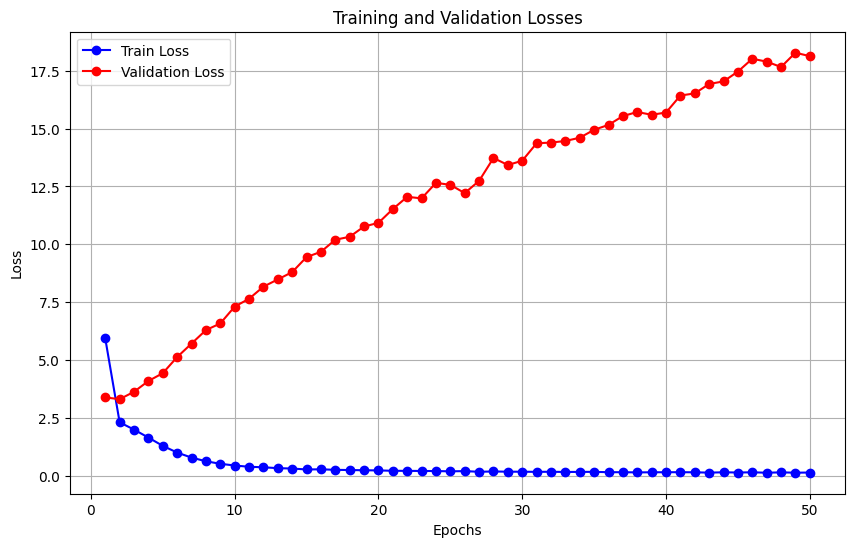

In [9]:
# plots losses

epochs = range(1, len(losses_train) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses_train, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, losses_val, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Predict on test
y_test_pred = model.predict(X_test)
y_test_pred

# Ensure y_test_pred is on the CPU before converting it to NumPy
y_test_pred_cpu = y_test_pred.cpu().numpy()

# Now you can calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred_cpu)

print(f"Accuracy: {accuracy * 100:.2f}%")

# Ensure tensors are converted to numpy
y_test = y_test.cpu().detach().numpy()
y_test_pred = y_test_pred.cpu().detach().numpy()

Accuracy: 7.59%


Accuracy: 0.0759
Precision: 0.0759
Recall: 0.0759
F1 Score: 0.0759
Accuracy for class 0: 6.19%
Accuracy for class 1: 7.11%
Accuracy for class 2: 9.49%
Accuracy for class 3: 4.97%
Accuracy for class 4: 6.04%
Accuracy for class 5: 5.30%
Accuracy for class 6: 2.40%
Accuracy for class 7: 7.21%
Accuracy for class 8: 11.06%
Accuracy for class 9: 5.85%
Accuracy for class 10: 11.80%
Accuracy for class 11: 6.33%
Accuracy for class 12: 18.53%


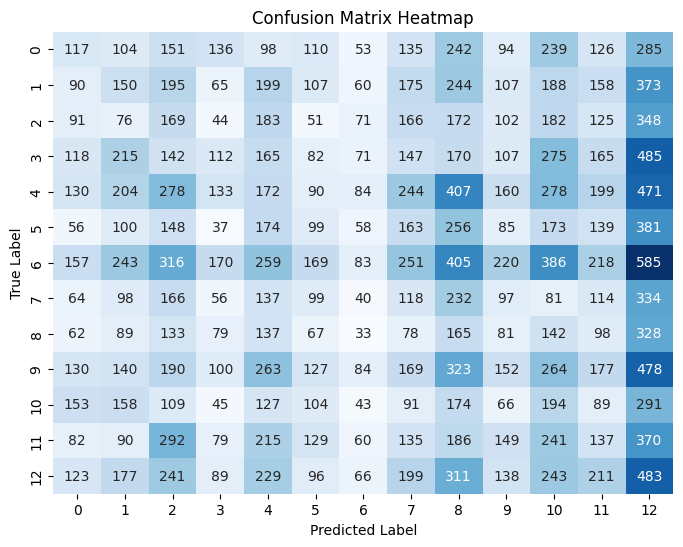

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate overall metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='micro')  # 'micro' for multi-class
recall = recall_score(y_test, y_test_pred, average='micro')  # 'micro' for multi-class
f1 = f1_score(y_test, y_test_pred, average='micro')  # 'micro' for multi-class

# Print overall metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculate accuracy per class
class_accuracies = {}
for i, label in enumerate(np.unique(y_test)):
    true_positives = conf_matrix[i, i]
    total_samples = conf_matrix[i].sum()
    class_accuracy = true_positives / total_samples if total_samples > 0 else 0.0
    class_accuracies[label] = class_accuracy
    print(f"Accuracy for class {label}: {class_accuracy*100:.2f}%")

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
